In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import Sequential, regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/


cp: cannot stat 'kaggle-2.json': No such file or directory


In [3]:
! kaggle datasets download -d "ashfakyeafi/cat-dog-images-for-classification"


Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 96% 524M/545M [00:05<00:00, 129MB/s]
100% 545M/545M [00:05<00:00, 106MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
data=pd.read_csv('/content/cat_dog.csv')

In [6]:
data.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [14]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Add the full image path to the DataFrame
data["image_path"] = data["image"].apply(lambda x: os.path.join("/content/cat_dog", x))

# Filter out files that are not present in the directory
data = data[data["image_path"].apply(os.path.exists)]

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["labels"], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["labels"], random_state=42)

# Data generators for memory efficiency
image_size = (64,64)  # Resize all images to 128x128
batch_size = 32

def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["labels"].values))
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["labels"].values))
val_dataset = val_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["labels"].values))
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 105s 192ms/step - accuracy: 0.7823 - loss: 0.5187 - val_accuracy: 0.8110 - val_loss: 0.4096
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 179ms/step - accuracy: 0.8412 - loss: 0.3414 - val_accuracy: 0.8263 - val_loss: 0.3886
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 173ms/step - accuracy: 0.8721 - loss: 0.2884 - val_accuracy: 0.8265 - val_loss: 0.4041


In [18]:
# Evaluate testing accuracy
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.8143 - loss: 0.3991
Test Loss: 0.3911, Test Accuracy: 0.8204


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━

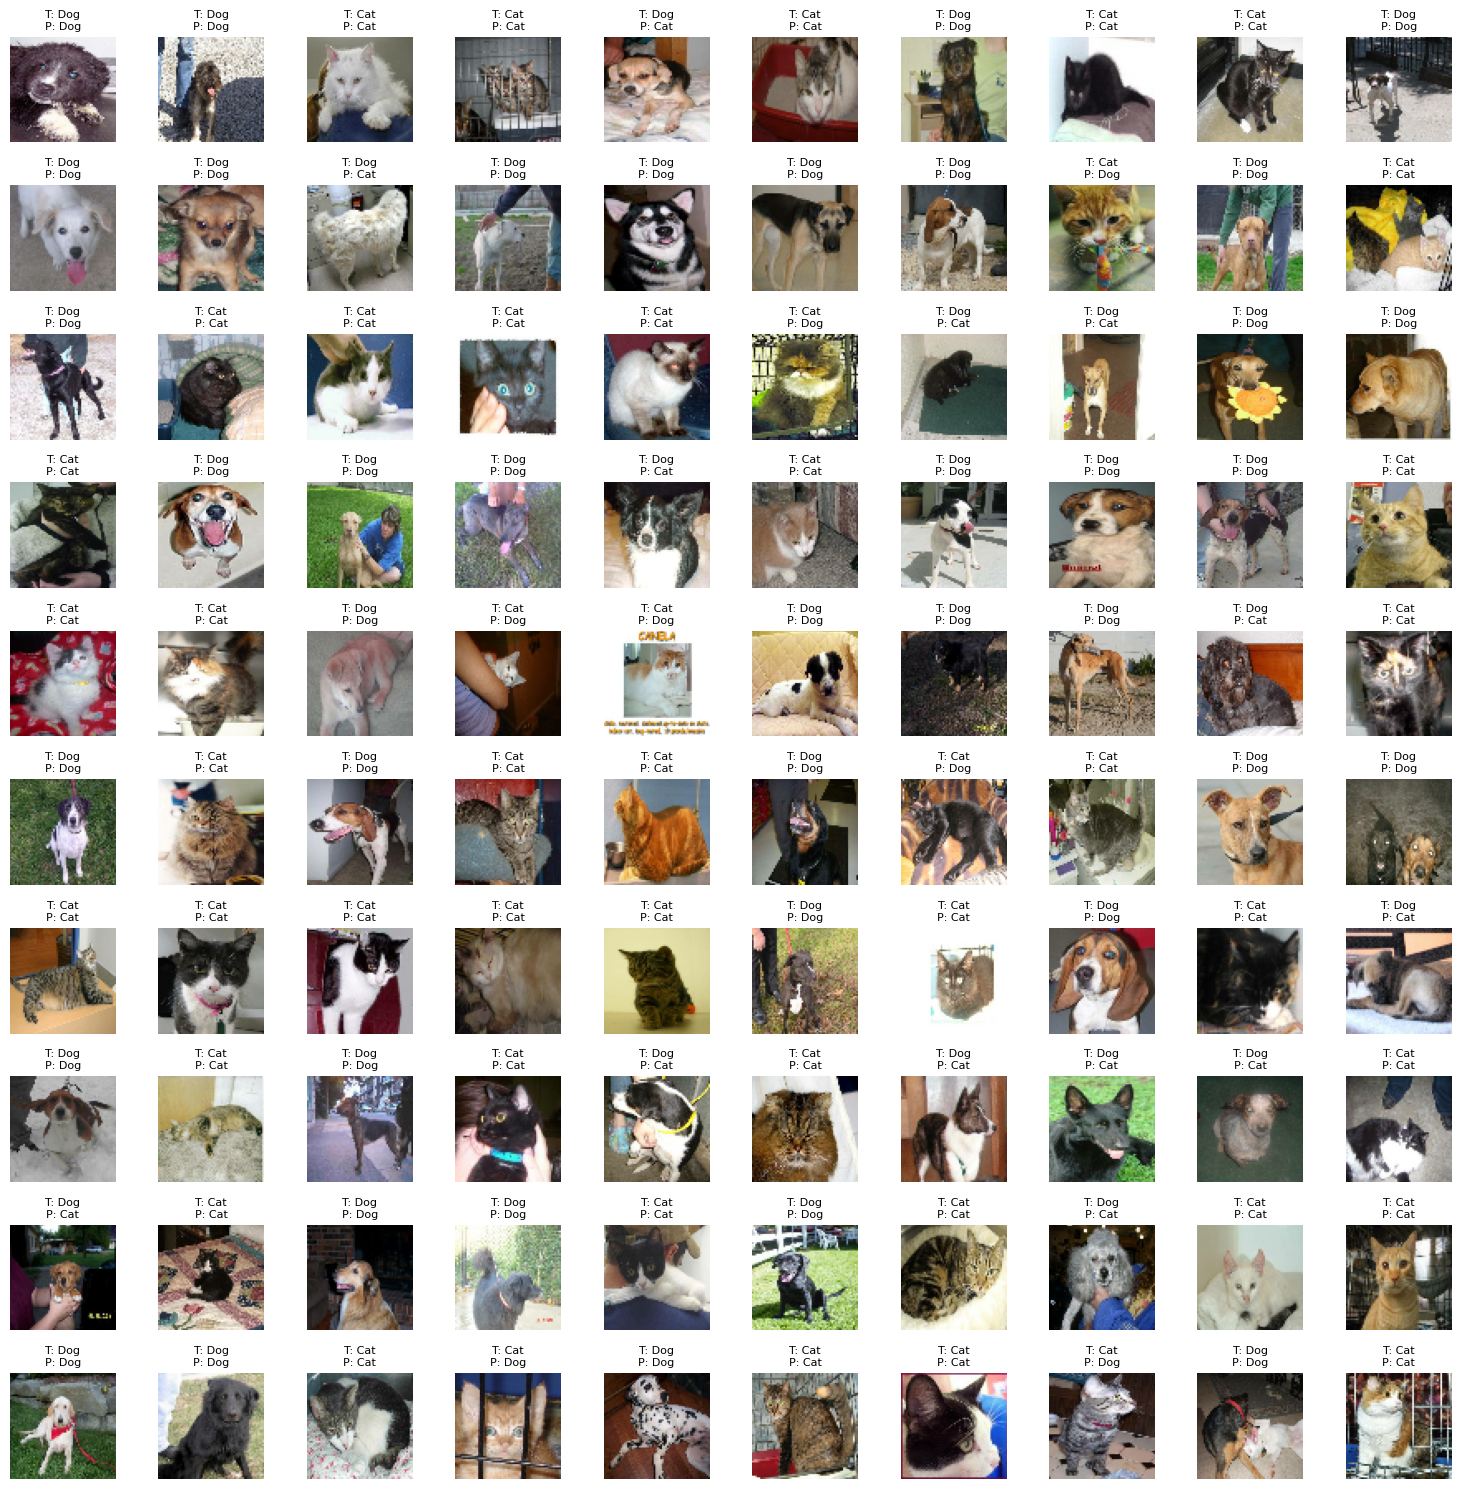

In [19]:
# Sample 50 images from the test dataset
sample_dataset = test_dataset.unbatch().take(100)

# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

# Collect the images, true labels, and predictions
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

# Plot the 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')  # Remove axes

    # Set title with true label and predicted label
    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"T: {true_label}\nP: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()
